In [15]:
%pip install torch numpy transformers datasets gensim scikit-learn seqeval
%pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Part I

Download the dataset from HuggingFace

In [2]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 609.58it/s]


In [3]:
dataset.set_format("torch")
dataset.column_names

{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [4]:
import torch
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': tensor([22, 42, 16, 21, 35, 37, 16, 21,  7]),
 'chunk_tags': tensor([11, 21, 11, 12, 21, 22, 11, 12,  0]),
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

In [1]:
from datasets import load_dataset

dataset = load_dataset("conll2003")
dataset.set_format("torch", columns=["tokens", "ner_tags"])
dataset.column_names

/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 622.98it/s]


{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [2]:
dataset['train'][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

### EDA

In [2]:
# create a word count dictionary from training data
word_list = []
for row in dataset['train']:
    word_list.extend(row['tokens'])
from collections import Counter
import numpy as np
counter = Counter(np.array(word_list))
counter

Counter({'EU': 24,
         'rejects': 1,
         'German': 85,
         'call': 30,
         'to': 3382,
         'boycott': 5,
         'British': 93,
         'lamb': 3,
         '.': 7374,
         'Peter': 31,
         'Blackburn': 11,
         'BRUSSELS': 17,
         '1996-08-22': 125,
         'The': 1127,
         'European': 86,
         'Commission': 49,
         'said': 1846,
         'on': 2040,
         'Thursday': 285,
         'it': 553,
         'disagreed': 2,
         'with': 840,
         'advice': 5,
         'consumers': 9,
         'shun': 1,
         'until': 53,
         'scientists': 6,
         'determine': 11,
         'whether': 45,
         'mad': 13,
         'cow': 12,
         'disease': 35,
         'can': 71,
         'be': 525,
         'transmitted': 2,
         'sheep': 12,
         'Germany': 143,
         "'s": 1536,
         'representative': 7,
         'the': 7243,
         'Union': 46,
         'veterinary': 8,
         'committee': 22,
    

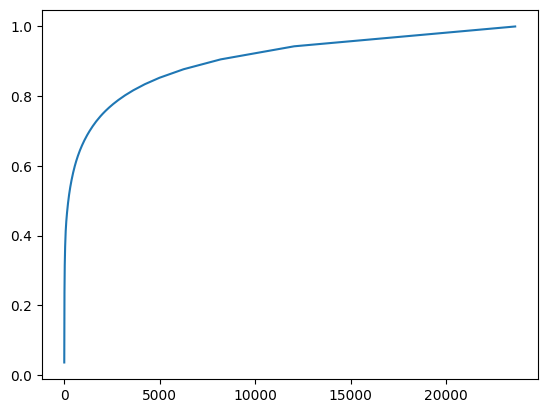

In [8]:
# sort counts by descending order and create a histogram of word covrege
counts = np.array(list(counter.values()))
counts = np.sort(counts)[::-1]
total_words = counts.sum()
counts = np.cumsum(counts)/total_words
from matplotlib import pyplot as plt
plt.plot(counts)
plt.show()

### Dataset

In [4]:
# choose 20000 most common words and create two way dictionaries
elements = counter.most_common(20000)
words_to_ids = {e[0]:i for e, i in zip(elements, range(len(elements)))}
words_to_ids['<UNK>'] = len(words_to_ids)
ids_to_words = {v:k for k, v in words_to_ids.items()}

In [5]:
import torch
convert_item = lambda x: { 'tokens': [words_to_ids.get(w, words_to_ids['<UNK>']) for w in x['tokens']] }
convert_item(dataset['train'][0])

{'tokens': [956, 11982, 232, 761, 5, 4146, 208, 6181, 0]}

In [6]:
# convert dataset to ids
for name in ['train', 'validation', 'test']:
    dataset[name] = dataset[name].map(convert_item, batched=False)

Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-dd796fdc36945aad.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-40cb9ee1eec1d9d0.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-8d8b0dcd70f1d28d.arrow


In [7]:
dataset['train'][0]

{'tokens': tensor([  956, 11982,   232,   761,     5,  4146,   208,  6181,     0]),
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

In [7]:
from torch.nn.utils.rnn import pack_sequence
def collate_fn(batch):
    tokens = pack_sequence([ exmp['tokens'] for exmp in batch ], enforce_sorted=False)
    ner_tags = pack_sequence([ exmp['ner_tags'] for exmp in batch ], enforce_sorted=False)
    return tokens, ner_tags

#### build embedding matrix

In [8]:
# load glove
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-300")

print("glove model loaded")

vectors = []
for id in range(len(words_to_ids)-1):
    try:
        vectors.append(model.get_vector(ids_to_words[id]))
    except KeyError:
        vectors.append(torch.zeros((300,)))
vectors.append(torch.zeros((300,)))

vectors = torch.tensor(vectors, dtype=torch.float)
vectors.shape

glove model loaded


/tmp/ipykernel_196952/3854162063.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  vectors = torch.tensor(vectors, dtype=torch.float)


torch.Size([20001, 300])

### Model

In [9]:
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence, pack_sequence, unpack_sequence
from collections import OrderedDict

class IMDBLangModel(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        # dimentions of activation layers
        self.word_id_dict = kwargs['word_id_dict']
        self.id_word_dict = kwargs['id_word_dict']
        self.embeddings = kwargs['embeddings']
        self.token_count = len(self.word_id_dict)
        self.input_size = kwargs['embedding_dim']
        self.hidden_size = 2*kwargs['embedding_dim']
        self.num_layers = kwargs['num_layers']
        self.class_count = kwargs['class_count']

        # model layers
        embeddings = nn.Embedding.from_pretrained(self.embeddings, freeze=False)
        gru = nn.GRU(input_size=self.input_size,
                      hidden_size=self.hidden_size,
                      num_layers=self.num_layers,
                      bidirectional=True)
        
        ff = nn.Sequential(OrderedDict([
            (f"ff_1_{2*self.num_layers*self.hidden_size}_to_{2*self.hidden_size*self.num_layers}", 
            nn.Linear(in_features=2*self.num_layers*self.hidden_size,
                      out_features=2*self.hidden_size*self.num_layers)),
            (f"ff_relu_1",nn.ReLU6()),
            (f"ff_2_{2*self.num_layers*self.hidden_size}_to_{self.class_count}",
            nn.Linear(in_features=2*self.hidden_size*self.num_layers,
                      out_features=self.class_count))
        ]))

        # full model
        self.model = nn.ModuleDict({
            "embeddings":embeddings,
            "gru":gru,
            "ff":ff
        })

    def forward(self,x:PackedSequence):
        # apply embeddings
        x = unpack_sequence(x)
        embeddings = [self.model["embeddings"](xi) for xi in x]
        x = pack_sequence(embeddings,enforce_sorted=False)

        # feed gru with sequence
        output, c_n = self.model["gru"](x)
        
        # run a fully connected layer on prompt-layer embedding
        y_pred = [self.model["ff"](out) for out in unpack_sequence(output)] 
        
        return y_pred

### Trainer

In [10]:
output_path = 'logs_and_models'

In [11]:
from torch.utils.data import dataloader
from torch.optim import Adam
import torch
from torch.utils import tensorboard
from os.path import isfile
from torch import nn
import tqdm
import numpy as np
from typing import Callable

class Trainer():
    def __init__(self,model:nn.Module,train_dataset,val_dataset,test_dataset,
                train_sample_count: int, validation_sample_count: int, lr: float, 
                batch_size: int, test_batch_size: int, num_epochs: int, 
                model_file_name: str, loss_func: Callable, load_checkpoint: bool,
                workers: int, collate_fn: Callable = None):
      # save the model
      self.model = model
      
      # create data loaders
      self.train_loader = dataloader.DataLoader(
          train_dataset,batch_size,
          sampler=dataloader.RandomSampler(
                  train_dataset,
                  num_samples=train_sample_count
          ), 
          collate_fn=collate_fn,
          num_workers=workers
      )

      self.val_loader = dataloader.DataLoader(
          val_dataset,batch_size,
          sampler=dataloader.RandomSampler(
              val_dataset,
              num_samples=validation_sample_count
          ),
          collate_fn=collate_fn,
          num_workers=workers
      )

      self.test_loader = dataloader.DataLoader(
          test_dataset,
          test_batch_size,
          shuffle=False,
          collate_fn=collate_fn,
          num_workers=workers
      )

      # name to save logs and and model
      self.model_file = output_path + "/" +model_file_name
      
      # hyper parameters
      self.num_epochs = num_epochs
      self.optimizer = Adam(self.model.parameters(), lr=lr)
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.loss_func = loss_func
      self.load_checkpoint = load_checkpoint
      self.train_sample_count = train_sample_count
      self.validation_sample_count = validation_sample_count
      self.test_count = len(test_dataset)//test_batch_size + \
        int(len(test_dataset)%test_batch_size>0)
      self.batch_size = batch_size

      # create log
      self.board = tensorboard.SummaryWriter(self.model_file)
      self.model_file = self.model_file + ".pkl"
      
      
    def train_one_epoch(self,epoch,total_train, test_func) -> float:
      train_loss_list =[]
      metric_list = []
      for idx, (x,y) in tqdm.tqdm(enumerate(self.train_loader),
          desc=f"epoch num {epoch+1}",total=total_train):

          # predict
          x = x.to(self.device)
          y = y.to(self.device)
          y_pred = self.model(x)
          
          # backward pass
          loss = self.loss_func(y_pred,y)
          loss.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()

          # test metric on train
          metric = test_func(y_pred,y)
          metric_list.append(float(metric))
          self.board.add_scalar(f"train_metric", float(metric), 
                                global_step=epoch*total_train+idx)
          
          # add batch loss to list
          train_loss_list.append(float(loss))
          self.board.add_scalar(f"train_loss",float(loss),
                                global_step=epoch*total_train+idx)
          del x,y,loss,y_pred
          torch.cuda.empty_cache()
      
      return float(np.mean(train_loss_list)), float(np.mean(metric_list))        

    
    def val_one_epoch(self,epoch,total_val, test_func) -> float:
      val_loss_list = []
      metric_list = []
      with torch.no_grad():
          for idx, (x,y) in tqdm.tqdm(enumerate(self.val_loader),
              desc=f"epoch num {epoch+1}",total=total_val):
              
              # predict
              x = x.to(self.device)
              y = y.to(self.device)
              y_pred = self.model(x)
              
              # calc loss
              val_loss = self.loss_func(y_pred,y)

              # calc metric
              metric = test_func(y_pred,y)
              metric_list.append(float(metric))
              self.board.add_scalar(f"val_metric", float(metric), 
                                global_step=epoch*total_val+idx)
              
              # log loss result
              val_loss_list.append(float(val_loss))
              self.board.add_scalar(f"val_loss",float(val_loss),
                                    global_step=epoch*total_val+idx)
              del x,y,val_loss,y_pred
              torch.cuda.empty_cache()
      return  float(np.mean(val_loss_list)), float(np.mean(metric_list))

    
    def test_epoch(self,total_test, func) -> list[tuple]:
      self.model = self.model.eval()
      prediction_dict = []
      with torch.no_grad():
        for idx, (x,y) in tqdm.tqdm(enumerate(self.test_loader),
          desc="test",total=total_test):

          # predict
          x:torch.Tensor = x.to(self.device)
          y = y.to(self.device)
          y_pred = self.model(x)
          prediction_dict.append(func(y_pred,y))
          del x,y,y_pred
          torch.cuda.empty_cache()
      return prediction_dict

    
    def full_train(self, test_func):
        total_train = self.train_sample_count//self.batch_size + \
                    int(self.train_sample_count%self.batch_size!=0)
        total_val = self.validation_sample_count//self.batch_size + \
                    int(self.validation_sample_count%self.batch_size!=0)

        # save model initiallization/ load model from checkpoint
        if not self.load_checkpoint or not isfile(self.model_file):
            torch.save(
                (
                    self.model.state_dict(),
                    self.model.word_id_dict,
                    self.model.id_word_dict
                ),
                self.model_file
            )
        else:
            state_dict, \
            self.model.word_id_dict, \
            self.model.id_word_dict = torch.load(self.model_file)
            print(self.model.load_state_dict(state_dict))

        # we save on minimum validation loss
        min_val_loss = 100
        self.model.train()
        self.model = self.model.to(self.device)
        for epoch in range(self.num_epochs):
          epoch_train_loss, epoch_train_metric = self.train_one_epoch(epoch,total_train, test_func)
          epoch_val_loss, epoch_val_metric = self.val_one_epoch(epoch,total_val, test_func)
          if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save(
                (
                    self.model.state_dict(),
                    self.model.word_id_dict,
                    self.model.id_word_dict
                ),
                self.model_file
            )
          print(f"epoch {epoch+1}/{self.num_epochs} loss: {epoch_train_loss} metric: {epoch_train_metric} val_loss: {epoch_val_loss} val_metric: {epoch_val_metric}")
        return self.test_epoch(self.test_count, test_func)


### Training

In [12]:
def accuracy(y_pred, y):
    y = unpack_sequence(y)
    accuracy_list = []
    for pred, label in zip(y_pred, y):
        accuracy_list.append(torch.sum(pred.argmax(dim=-1) == label)/len(label))
    return torch.mean(torch.stack(accuracy_list)).item()

In [13]:
import numpy as np

train_dataset, validation_dataset, test_dataset = dataset['train'], dataset['validation'], dataset['test']

print(f"train: {len(train_dataset)}, val: {len(validation_dataset)}, test: {len(test_dataset)}")

# create model
model = IMDBLangModel(embeddings = vectors,
                    word_id_dict=words_to_ids, 
                    id_word_dict=ids_to_words, 
                    embedding_dim=300, 
                    num_layers=1,
                    class_count = 9)

print("model created")

base_loss = nn.CrossEntropyLoss()
def loss_func(y_pred, y):
    y = unpack_sequence(y)
    loss_list = []
    for examp in range(len(y)):
        sent_loss_list = []
        for pred,label in zip(y_pred[examp],y[examp]):
           sent_loss_list.append(base_loss(pred,label))
        loss_list.append(torch.mean(torch.stack(sent_loss_list)))
    return torch.mean(torch.stack(loss_list))

# create trainer
trainer = Trainer(model=model,
                train_dataset=train_dataset, 
                val_dataset=validation_dataset, 
                test_dataset=test_dataset,
                train_sample_count=len(train_dataset), 
                validation_sample_count=len(validation_dataset),
                lr=1e-3, 
                batch_size=256,
                test_batch_size=2, 
                num_epochs=0, 
                model_file_name="ner_300_scratch_training", 
                loss_func=loss_func, 
                load_checkpoint=True,
                workers=1,
                collate_fn=collate_fn)

print("trainer created")

prediction = trainer.full_train(accuracy)
print()
print(f"model accuracy is: {np.mean(prediction)}")

train: 14041, val: 3250, test: 3453
model created
trainer created
<All keys matched successfully>


test: 100%|██████████| 1727/1727 [00:07<00:00, 245.58it/s]


model accuracy is: 0.9282798616266278


### Evaluation

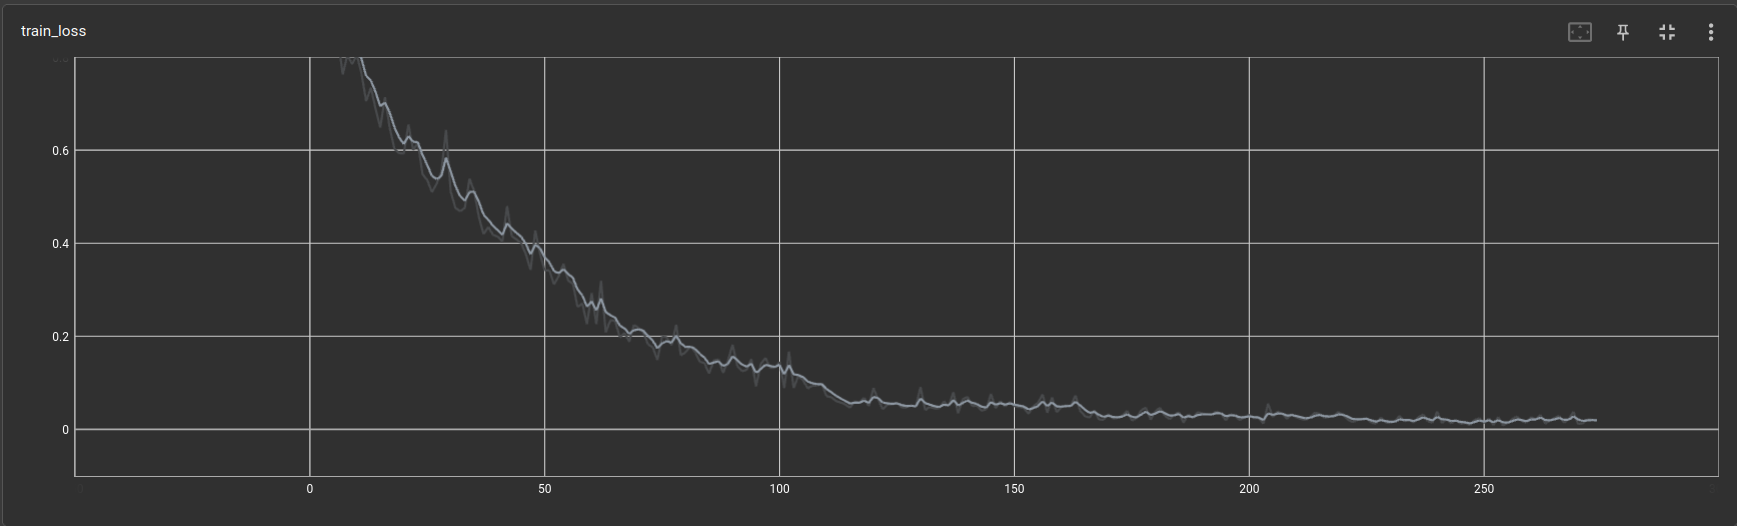

In [18]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_train_loss.png")

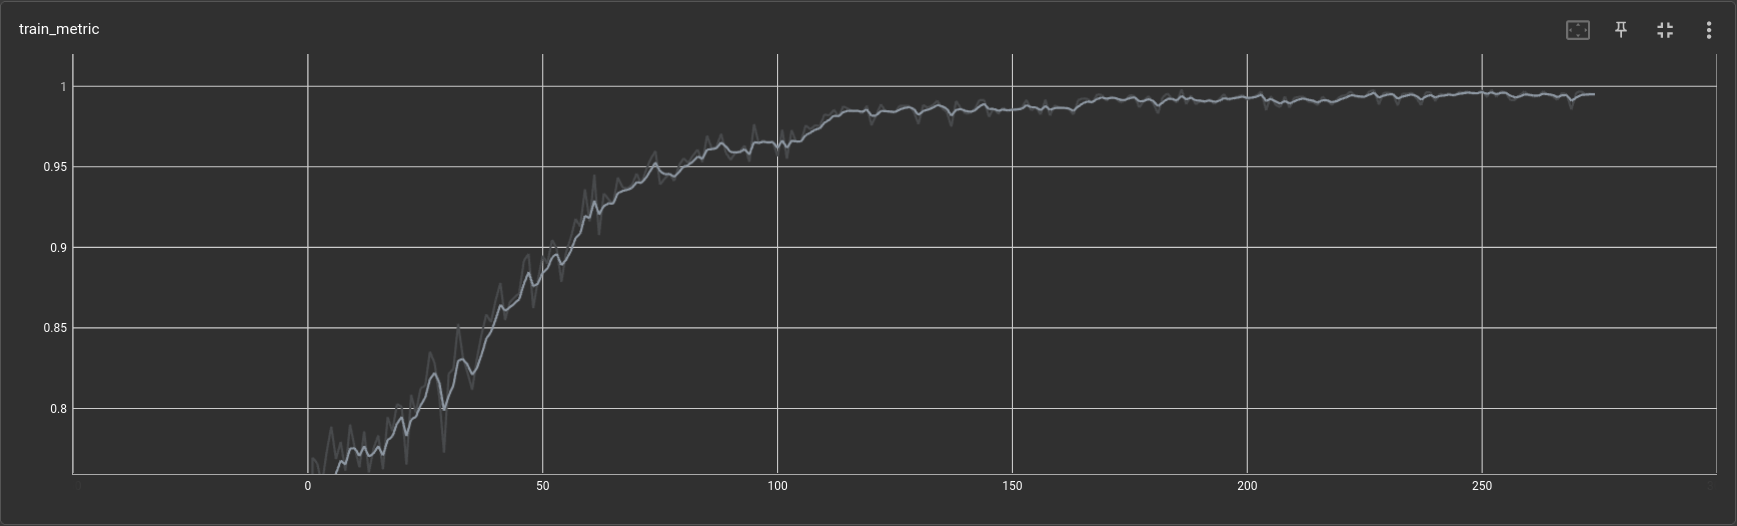

In [19]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_train_accuracy.png")

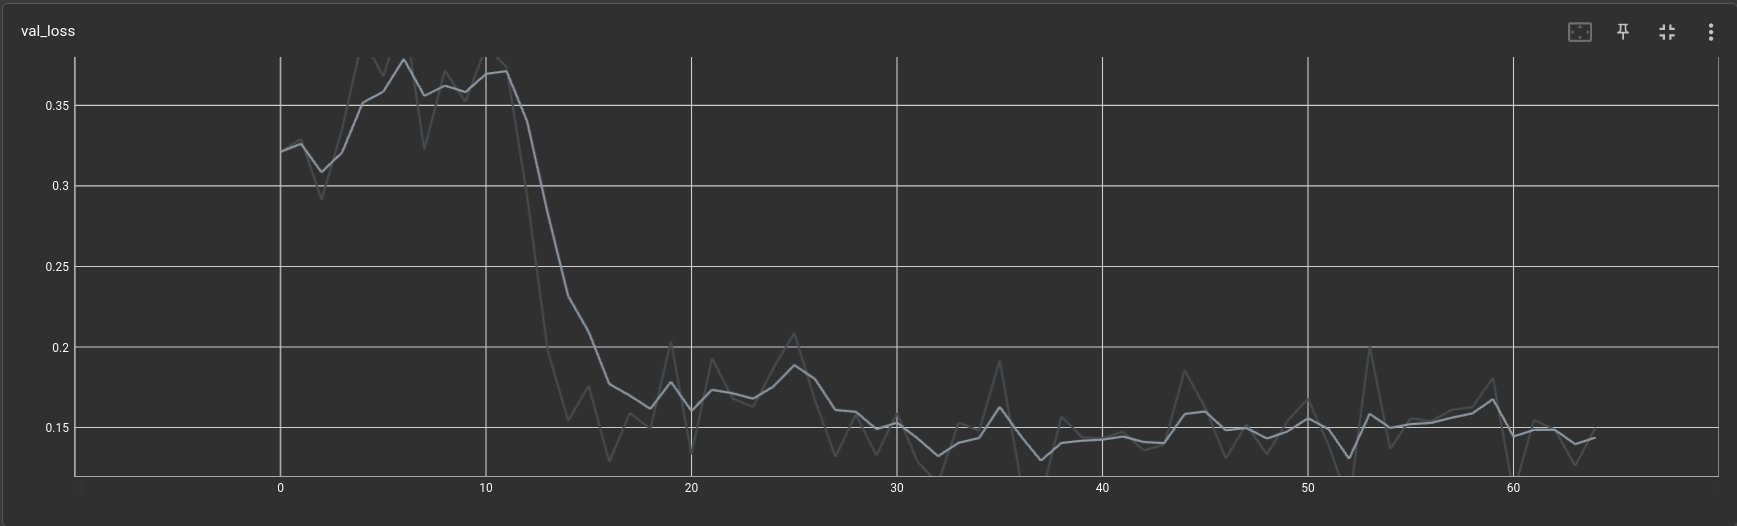

In [20]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_val_loss.png")

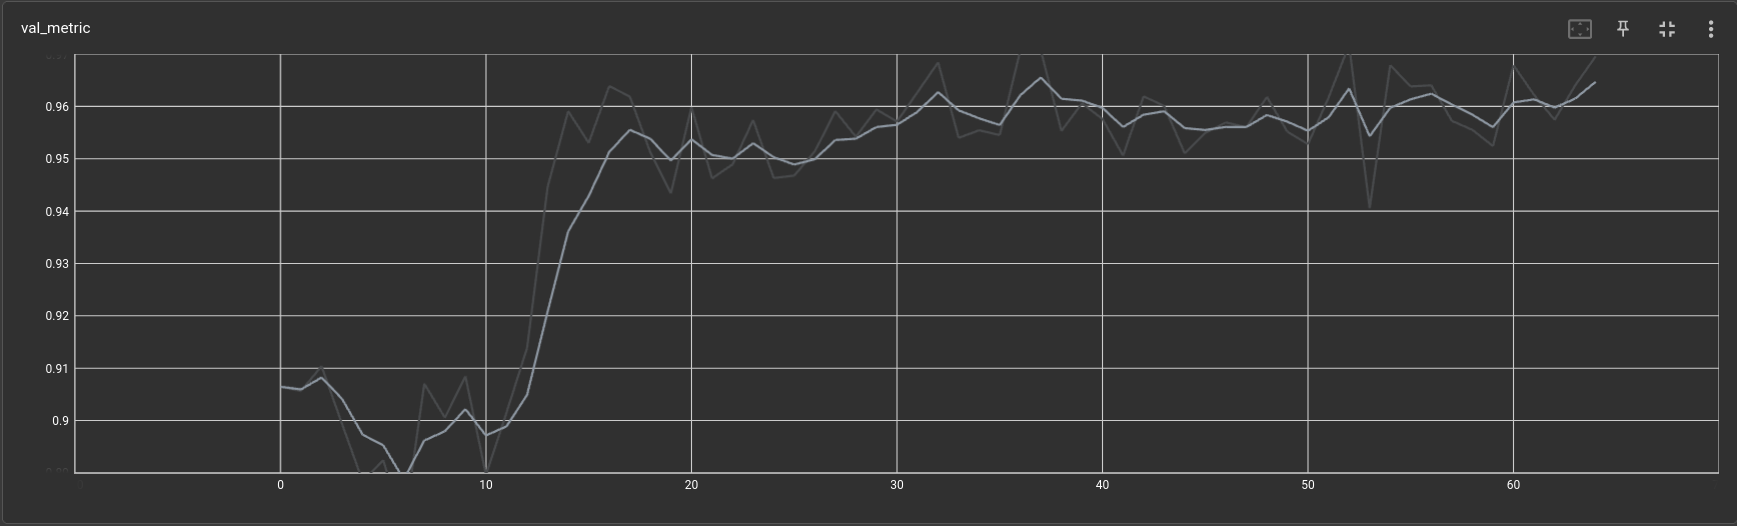

In [21]:
from PIL import Image
Image.open("logs_and_models/ner_300_scratch_training_val_accuracy.png")

### Metrics

In [14]:
def test_func(y_pred,y):
    y = unpack_sequence(y)
    return y, y_pred

In [16]:
from sklearn.metrics import confusion_matrix
results = trainer.test_epoch(trainer.test_count, test_func)

y = [pred.cpu() for result in results for sentence in result[0] for pred in sentence]
y_pred = [pred.argmax().cpu() for result in results for sentence in result[1] for pred in sentence]
print(y[0], y_pred[0])

test:   0%|          | 0/1727 [00:00<?, ?it/s]

test: 100%|██████████| 1727/1727 [00:07<00:00, 224.30it/s]


tensor(0) tensor(0)


In [31]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y, y_pred)
cm

array([[37801,   111,    76,    86,    55,    75,    10,    52,    57],
       [  271,  1255,    23,    30,     3,    24,     2,     9,     0],
       [  241,    17,   882,     1,     9,     1,     3,     0,     2],
       [  285,    66,     0,  1180,    28,    75,     0,    26,     1],
       [  126,     4,    48,    30,   589,     4,    16,     3,    15],
       [  145,    25,     3,    62,     1,  1415,     3,    13,     1],
       [   44,     1,     9,     0,    32,     1,   167,     0,     3],
       [  169,    23,     0,    30,     2,    16,     1,   455,     6],
       [   51,     0,     7,     1,     4,     0,     2,    27,   124]])

In [36]:
cm = cm / cm.sum(axis=-1, keepdims=True)

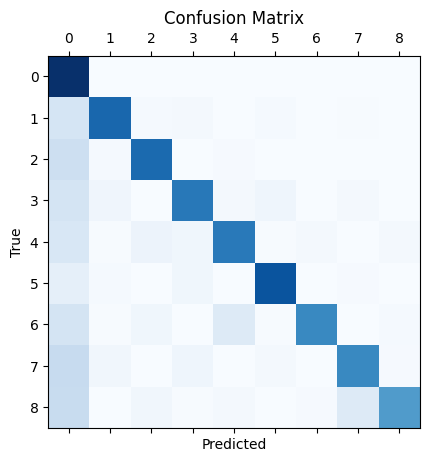

In [37]:
# Print the confusion matrix
plt.matshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Confusion matrix looks great, so no tuning is required.

## Part II

### Dataset


In [1]:
model_name = "bert-base-cased"

We chose this pretrained model because bert is a good base model for NER, even appearing in the original paper. \
the cased version is suitable for NER because many NERs are upper case

In [2]:
def load_tokenizer():
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

In [3]:
tokenizer = load_tokenizer()
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
def load_dataset(k):
    from datasets import load_dataset

    dataset = load_dataset("conll2003")

    # select random k% indices
    indices = np.random.choice(len(dataset["train"]), len(dataset['train'])*k//100, replace=False)

    dataset['train'] = dataset['train'].select(indices)
    # convert dataset to ids
    for name in ['train', 'validation', 'test']:
        dataset[name] = dataset[name].map(tokenize_and_align_labels, batched=True)
    return dataset

In [5]:
dataset = load_dataset(1)

Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 484.98it/s]
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-6b40c29a6848521b.arrow
Loading cached processed dataset at /home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-437cb2368803ba37.arrow


In [6]:
print()
print("dataset size:",str(len(dataset['train'])),"example", dataset["train"][0])


dataset size: 140 example {'id': '7412', 'tokens': ['Interacciones', 'brokerage', 'on', 'Monday', 'raised', 'its', 'forecasts', 'for', '1996', 'gross', 'domestic', 'product', 'growth', 'to', '4.3', 'percent', 'from', '3.8', 'percent', ',', 'but', 'it', 'kept', 'its', '1997', 'projection', 'unchanged', 'at', '4.5', 'percent', ',', 'a', 'statement', 'said', '.'], 'pos_tags': [24, 21, 15, 22, 38, 29, 24, 15, 11, 16, 16, 21, 21, 35, 11, 21, 15, 11, 21, 6, 10, 28, 38, 29, 11, 21, 16, 15, 11, 21, 6, 12, 21, 38, 7], 'chunk_tags': [11, 12, 13, 11, 21, 11, 12, 13, 11, 12, 12, 12, 12, 13, 11, 12, 13, 11, 12, 0, 0, 11, 21, 11, 12, 12, 1, 13, 11, 12, 0, 11, 12, 21, 0], 'ner_tags': [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [101, 11300, 7409, 16012, 1279, 24535, 2553, 1113, 6356, 2120, 1157, 24647, 1116, 1111, 1820, 10272, 4500, 3317, 3213, 1106, 125, 119, 124, 3029, 1121, 124, 119, 129, 3029, 117, 1133, 1122, 2023, 1157,

### Model

In [7]:
label_list = dataset["train"].features["ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [8]:
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def reload_model():
    return AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

In [9]:
from datasets import load_metric
metric_seqeval = load_metric("seqeval")
example = dataset["train"][0]

labels = [label_list[i] for i in example["ner_tags"]]
metric_seqeval.compute(predictions=[labels], references=[labels])

/tmp/ipykernel_116422/3224873647.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_seqeval = load_metric("seqeval")


{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [10]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### Trainer

In [11]:
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments
from transformers import Trainer

def reload_trainer(log_dir, dataset, model):

    training_args = TrainingArguments(
        output_dir=log_dir,
        num_train_epochs=5,
        learning_rate=2e-5,
        per_device_train_batch_size=16,   
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        warmup_steps=500, 
        eval_steps=60,
        save_steps=60,
        evaluation_strategy="steps",
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience = 6)]
    )
    return trainer

### Evaluation


In [12]:
def output_confusion_matrix(true_labels, true_predictions):
    true_labels = [label for lst in true_labels for label in lst]
    true_predictions = [label for lst in true_predictions for label in lst]
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_labels, true_predictions)
    cm = cm / cm.sum(axis=-1, keepdims=True)
    import matplotlib.pyplot as plt

    # Print the confusion matrix
    plt.matshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [13]:
def eval(trainer, dataset):
    predictions, labels, _ = trainer.predict(dataset["test"])
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)

    output_confusion_matrix(true_labels, true_predictions)
    return results

In [14]:
import pandas as pd
def pretty_print(results:dict):
    overall = {
        'overall_precision': [results['overall_precision']],
        'overall_recall': [results['overall_recall']],
        'overall_f1': [results['overall_f1']],
        'overall_accuracy': [results['overall_accuracy']]
    }
    print(pd.DataFrame(overall))

    print()

    del results['overall_accuracy']
    del results['overall_f1']
    del results['overall_recall']
    del results['overall_precision']

    print(pd.DataFrame(results))    

---------------------------------------------------
starting run on training set of 1%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'train_runtime': 5.0608, 'train_samples_per_second': 138.318, 'train_steps_per_second': 8.892, 'train_loss': 2.3458309597439237, 'epoch': 5.0}


100%|██████████| 54/54 [00:06<00:00,  8.02it/s]


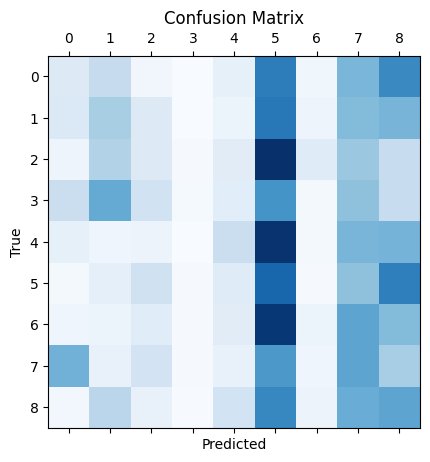

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.015728        0.069936     0.02568          0.205384

                   LOC        MISC          ORG          PER
precision     0.024528    0.008549     0.045104     0.012559
recall        0.054556    0.149573     0.070439     0.050711
f1            0.033842    0.016174     0.054994     0.020133
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 3%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.6281932592391968, 'eval_precision': 0.0037220843672456576, 'eval_recall': 0.0010623229461756375, 'eval_f1': 0.0016528925619834713, 'eval_accuracy': 0.7954990847421126, 'eval_runtime': 7.0396, 'eval_samples_per_second': 490.513, 'eval_steps_per_second': 7.671, 'epoch': 2.22}


 89%|████████▉ | 120/135 [00:20<00:01,  9.39it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 89%|████████▉ | 120/135 [00:27<00:01,  9.39it/s]

{'eval_loss': 0.6362273693084717, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0715, 'eval_samples_per_second': 488.296, 'eval_steps_per_second': 7.636, 'epoch': 4.44}


100%|██████████| 135/135 [00:31<00:00,  4.31it/s]


{'train_runtime': 31.3255, 'train_samples_per_second': 67.198, 'train_steps_per_second': 4.31, 'train_loss': 1.4195057056568288, 'epoch': 5.0}


100%|██████████| 54/54 [00:06<00:00, 10.08it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 54/54 [00:06<00:00,  7.89it/s]


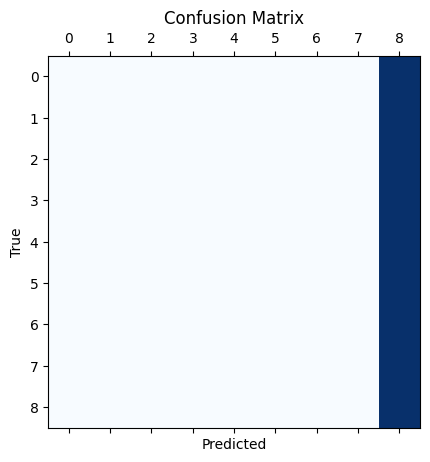

   overall_precision  overall_recall  overall_f1  overall_accuracy
0                0.0             0.0         0.0          0.825304

              LOC   MISC     ORG     PER
precision     0.0    0.0     0.0     0.0
recall        0.0    0.0     0.0     0.0
f1            0.0    0.0     0.0     0.0
number     1668.0  702.0  1661.0  1617.0

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 5%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.3708831071853638, 'eval_precision': 0.021212121212121213, 'eval_recall': 0.003718130311614731, 'eval_f1': 0.006327206990057246, 'eval_accuracy': 0.8086787983202326, 'eval_runtime': 7.1941, 'eval_samples_per_second': 479.976, 'eval_steps_per_second': 7.506, 'epoch': 1.36}


 55%|█████▍    | 120/220 [00:21<00:10,  9.47it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 120/220 [00:28<00:10,  9.47it/s]

{'eval_loss': 0.611586332321167, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.2348, 'eval_samples_per_second': 477.279, 'eval_steps_per_second': 7.464, 'epoch': 2.73}


 82%|████████▏ | 180/220 [00:42<00:04,  8.85it/s]

{'eval_loss': 0.3104669451713562, 'eval_precision': 0.5097560975609756, 'eval_recall': 0.5550637393767706, 'eval_f1': 0.5314460077979319, 'eval_accuracy': 0.9268439754495531, 'eval_runtime': 7.1507, 'eval_samples_per_second': 482.886, 'eval_steps_per_second': 7.552, 'epoch': 4.09}


100%|██████████| 220/220 [00:49<00:00,  4.48it/s]


{'train_runtime': 49.1249, 'train_samples_per_second': 71.451, 'train_steps_per_second': 4.478, 'train_loss': 0.8545691056685014, 'epoch': 5.0}


100%|██████████| 54/54 [00:06<00:00,  7.84it/s]


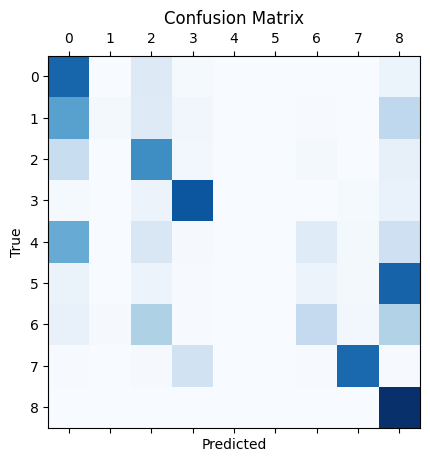

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.509756        0.555064    0.531446          0.926844

                   LOC        MISC          ORG          PER
precision     0.500426    0.366667     0.398301     0.650650
recall        0.705036    0.015670     0.479831     0.711812
f1            0.585366    0.030055     0.435281     0.679858
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 7%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.7831087112426758, 'eval_precision': 0.02294813253717363, 'eval_recall': 0.034702549575070823, 'eval_f1': 0.027627035027133692, 'eval_accuracy': 0.6626036394960698, 'eval_runtime': 7.2085, 'eval_samples_per_second': 479.017, 'eval_steps_per_second': 7.491, 'epoch': 0.97}


 39%|███▊      | 120/310 [00:20<00:19,  9.73it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▊      | 120/310 [00:28<00:19,  9.73it/s]

{'eval_loss': 0.6534881591796875, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.0676, 'eval_samples_per_second': 488.571, 'eval_steps_per_second': 7.641, 'epoch': 1.94}


 58%|█████▊    | 180/310 [00:42<00:13,  9.38it/s]

{'eval_loss': 0.34523889422416687, 'eval_precision': 0.40427553444180525, 'eval_recall': 0.4520184135977337, 'eval_f1': 0.42681601604948594, 'eval_accuracy': 0.9084526757833531, 'eval_runtime': 7.1501, 'eval_samples_per_second': 482.927, 'eval_steps_per_second': 7.552, 'epoch': 2.9}


 77%|███████▋  | 240/310 [00:56<00:07,  9.69it/s]

{'eval_loss': 0.19433164596557617, 'eval_precision': 0.6890305266689031, 'eval_recall': 0.7273371104815864, 'eval_f1': 0.707665805340224, 'eval_accuracy': 0.9536771831592549, 'eval_runtime': 7.1305, 'eval_samples_per_second': 484.257, 'eval_steps_per_second': 7.573, 'epoch': 3.87}


 97%|█████████▋| 300/310 [01:12<00:01,  9.45it/s]

{'eval_loss': 0.1458546370267868, 'eval_precision': 0.7901150981719702, 'eval_recall': 0.8264872521246459, 'eval_f1': 0.8078920041536866, 'eval_accuracy': 0.9658447291913428, 'eval_runtime': 7.1998, 'eval_samples_per_second': 479.597, 'eval_steps_per_second': 7.5, 'epoch': 4.84}


100%|██████████| 310/310 [01:14<00:00,  4.17it/s]


{'train_runtime': 74.4056, 'train_samples_per_second': 65.99, 'train_steps_per_second': 4.166, 'train_loss': 0.7915849254977319, 'epoch': 5.0}


100%|██████████| 54/54 [00:07<00:00,  7.54it/s]


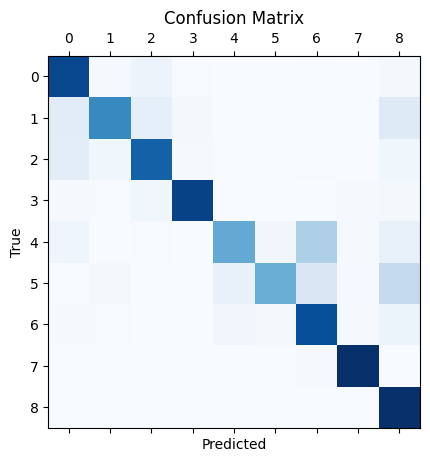

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.790115        0.826487    0.807892          0.965845

                   LOC        MISC          ORG          PER
precision     0.766435    0.629683     0.733857     0.953905
recall        0.859712    0.622507     0.786875     0.921459
f1            0.810398    0.626074     0.759442     0.937402
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 9%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.633639931678772, 'eval_precision': 0.010123734533183352, 'eval_recall': 0.0047804532577903685, 'eval_f1': 0.006494287432351174, 'eval_accuracy': 0.7801658231937116, 'eval_runtime': 7.184, 'eval_samples_per_second': 480.649, 'eval_steps_per_second': 7.517, 'epoch': 0.76}


 30%|███       | 120/395 [00:20<00:28,  9.53it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 30%|███       | 120/395 [00:27<00:28,  9.53it/s]

{'eval_loss': 0.6191298961639404, 'eval_precision': 1.0, 'eval_recall': 0.00017705382436260624, 'eval_f1': 0.00035404496371039125, 'eval_accuracy': 0.825325724130505, 'eval_runtime': 7.0481, 'eval_samples_per_second': 489.923, 'eval_steps_per_second': 7.662, 'epoch': 1.52}


                                                 
 46%|████▌     | 180/395 [00:41<00:23,  9.28it/s]

{'eval_loss': 0.30599939823150635, 'eval_precision': 0.4979325699745547, 'eval_recall': 0.5543555240793201, 'eval_f1': 0.5246313672922251, 'eval_accuracy': 0.9250134596748143, 'eval_runtime': 6.9404, 'eval_samples_per_second': 497.523, 'eval_steps_per_second': 7.781, 'epoch': 2.28}


                                                 
 61%|██████    | 240/395 [00:56<00:15, 10.07it/s]

{'eval_loss': 0.19309137761592865, 'eval_precision': 0.6471249598458079, 'eval_recall': 0.7133498583569405, 'eval_f1': 0.6786255684689237, 'eval_accuracy': 0.9473457521266286, 'eval_runtime': 7.185, 'eval_samples_per_second': 480.584, 'eval_steps_per_second': 7.516, 'epoch': 3.04}


                                                 
 76%|███████▌  | 300/395 [01:11<00:09,  9.55it/s]

{'eval_loss': 0.14118090271949768, 'eval_precision': 0.8022560246111776, 'eval_recall': 0.8310906515580736, 'eval_f1': 0.8164188190277415, 'eval_accuracy': 0.9668784322170776, 'eval_runtime': 7.3591, 'eval_samples_per_second': 469.214, 'eval_steps_per_second': 7.338, 'epoch': 3.8}


                                                 
 91%|█████████ | 360/395 [01:26<00:03,  9.27it/s]

{'eval_loss': 0.1309792697429657, 'eval_precision': 0.8153038767563907, 'eval_recall': 0.8526912181303116, 'eval_f1': 0.833578537429684, 'eval_accuracy': 0.9692473349843868, 'eval_runtime': 7.0006, 'eval_samples_per_second': 493.244, 'eval_steps_per_second': 7.714, 'epoch': 4.56}


100%|██████████| 395/395 [01:31<00:00,  4.34it/s]


{'train_runtime': 91.1132, 'train_samples_per_second': 69.309, 'train_steps_per_second': 4.335, 'train_loss': 0.5926385034488726, 'epoch': 5.0}


100%|██████████| 54/54 [00:06<00:00,  8.09it/s]


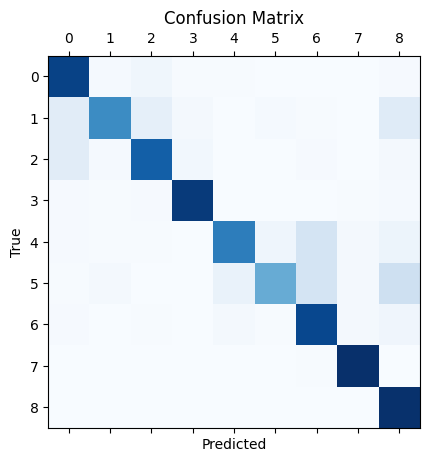

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.815304        0.852691    0.833579          0.969247

                   LOC        MISC          ORG          PER
precision     0.789668    0.636765     0.793246     0.941535
recall        0.898082    0.616809     0.806141     0.956092
f1            0.840393    0.626628     0.799642     0.948757
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 11%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.471448302268982, 'eval_precision': 0.0398936170212766, 'eval_recall': 0.0026558073654390935, 'eval_f1': 0.0049800796812749, 'eval_accuracy': 0.8184774415850113, 'eval_runtime': 7.3105, 'eval_samples_per_second': 472.333, 'eval_steps_per_second': 7.387, 'epoch': 0.62}


 25%|██▍       | 120/485 [00:20<00:37,  9.71it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 120/485 [00:28<00:37,  9.71it/s]

{'eval_loss': 0.6558875441551208, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.3409, 'eval_samples_per_second': 470.38, 'eval_steps_per_second': 7.356, 'epoch': 1.24}


 37%|███▋      | 180/485 [00:44<00:34,  8.90it/s]

{'eval_loss': 0.30554288625717163, 'eval_precision': 0.45444866920152094, 'eval_recall': 0.5290368271954674, 'eval_f1': 0.48891434181461185, 'eval_accuracy': 0.9211370733283084, 'eval_runtime': 7.3088, 'eval_samples_per_second': 472.445, 'eval_steps_per_second': 7.388, 'epoch': 1.86}


 49%|████▉     | 240/485 [00:59<00:24, 10.20it/s]

{'eval_loss': 0.17851009964942932, 'eval_precision': 0.7108190091001011, 'eval_recall': 0.7468130311614731, 'eval_f1': 0.7283716111207045, 'eval_accuracy': 0.9565414019597287, 'eval_runtime': 7.3695, 'eval_samples_per_second': 468.552, 'eval_steps_per_second': 7.327, 'epoch': 2.47}


 62%|██████▏   | 300/485 [01:13<00:18,  9.74it/s]

{'eval_loss': 0.139157235622406, 'eval_precision': 0.7811768639251087, 'eval_recall': 0.8273725212464589, 'eval_f1': 0.8036113499570077, 'eval_accuracy': 0.9651125228814472, 'eval_runtime': 7.2764, 'eval_samples_per_second': 474.545, 'eval_steps_per_second': 7.421, 'epoch': 3.09}


 74%|███████▍  | 360/485 [01:28<00:13,  9.50it/s]

{'eval_loss': 0.12652765214443207, 'eval_precision': 0.8143146522619852, 'eval_recall': 0.8541076487252125, 'eval_f1': 0.8337366055997235, 'eval_accuracy': 0.9692688704640896, 'eval_runtime': 7.531, 'eval_samples_per_second': 458.502, 'eval_steps_per_second': 7.17, 'epoch': 3.71}


 87%|████████▋ | 420/485 [01:45<00:07,  9.23it/s]

{'eval_loss': 0.1225847378373146, 'eval_precision': 0.8462074978204011, 'eval_recall': 0.859242209631728, 'eval_f1': 0.8526750417288939, 'eval_accuracy': 0.9727145472165393, 'eval_runtime': 7.2763, 'eval_samples_per_second': 474.556, 'eval_steps_per_second': 7.421, 'epoch': 4.33}


 99%|█████████▉| 480/485 [01:59<00:00, 10.15it/s]

{'eval_loss': 0.13548825681209564, 'eval_precision': 0.8318011576438543, 'eval_recall': 0.865084985835694, 'eval_f1': 0.848116646415553, 'eval_accuracy': 0.9704533218477441, 'eval_runtime': 7.2119, 'eval_samples_per_second': 478.789, 'eval_steps_per_second': 7.488, 'epoch': 4.95}


100%|██████████| 485/485 [02:02<00:00,  3.96it/s]


{'train_runtime': 122.34, 'train_samples_per_second': 63.103, 'train_steps_per_second': 3.964, 'train_loss': 0.4597133361187178, 'epoch': 5.0}


100%|██████████| 54/54 [00:07<00:00,  7.66it/s]


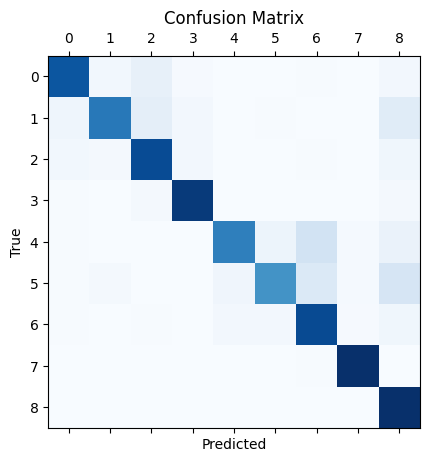

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.846207        0.859242    0.852675          0.972715

                   LOC        MISC          ORG          PER
precision     0.896154    0.690707     0.784768     0.934836
recall        0.838129    0.709402     0.856111     0.949289
f1            0.866171    0.699930     0.818889     0.942007
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 13%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.6224472522735596, 'eval_precision': 0.01710863986313088, 'eval_recall': 0.0035410764872521247, 'eval_f1': 0.005867683731846853, 'eval_accuracy': 0.8051685151286745, 'eval_runtime': 7.3094, 'eval_samples_per_second': 472.405, 'eval_steps_per_second': 7.388, 'epoch': 0.52}


 21%|██        | 119/575 [00:20<00:47,  9.70it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 120/575 [00:28<00:46,  9.70it/s]

{'eval_loss': 0.699685275554657, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.3474, 'eval_samples_per_second': 469.963, 'eval_steps_per_second': 7.35, 'epoch': 1.04}


 31%|███▏      | 180/575 [00:44<00:40,  9.85it/s]

{'eval_loss': 0.34061717987060547, 'eval_precision': 0.5145001705902422, 'eval_recall': 0.5339943342776204, 'eval_f1': 0.5240660295395309, 'eval_accuracy': 0.9233121567782923, 'eval_runtime': 7.359, 'eval_samples_per_second': 469.221, 'eval_steps_per_second': 7.338, 'epoch': 1.57}


 42%|████▏     | 240/575 [00:58<00:34,  9.64it/s]

{'eval_loss': 0.17855338752269745, 'eval_precision': 0.6898132983950213, 'eval_recall': 0.7457507082152974, 'eval_f1': 0.7166921898928024, 'eval_accuracy': 0.9558738020889416, 'eval_runtime': 7.2129, 'eval_samples_per_second': 478.725, 'eval_steps_per_second': 7.487, 'epoch': 2.09}


 52%|█████▏    | 300/575 [01:13<00:28,  9.58it/s]

{'eval_loss': 0.1306353658437729, 'eval_precision': 0.801287480941894, 'eval_recall': 0.8374645892351275, 'eval_f1': 0.8189767119729894, 'eval_accuracy': 0.9673952837299451, 'eval_runtime': 7.2287, 'eval_samples_per_second': 477.681, 'eval_steps_per_second': 7.47, 'epoch': 2.61}


 63%|██████▎   | 360/575 [01:28<00:22,  9.44it/s]

{'eval_loss': 0.11109016835689545, 'eval_precision': 0.8382069690071792, 'eval_recall': 0.847556657223796, 'eval_f1': 0.8428558852011621, 'eval_accuracy': 0.9716808441908044, 'eval_runtime': 7.3255, 'eval_samples_per_second': 471.369, 'eval_steps_per_second': 7.372, 'epoch': 3.13}


 73%|███████▎  | 420/575 [01:43<00:17,  9.00it/s]

{'eval_loss': 0.12631481885910034, 'eval_precision': 0.8439084076210452, 'eval_recall': 0.8548158640226629, 'eval_f1': 0.8493271176004925, 'eval_accuracy': 0.9726930117368364, 'eval_runtime': 7.2171, 'eval_samples_per_second': 478.45, 'eval_steps_per_second': 7.482, 'epoch': 3.65}


 83%|████████▎ | 480/575 [01:58<00:10,  9.15it/s]

{'eval_loss': 0.1259559690952301, 'eval_precision': 0.8527332298672184, 'eval_recall': 0.8755311614730878, 'eval_f1': 0.8639818293002534, 'eval_accuracy': 0.9735544309249489, 'eval_runtime': 7.2734, 'eval_samples_per_second': 474.743, 'eval_steps_per_second': 7.424, 'epoch': 4.17}


 87%|████████▋ | 500/575 [02:02<00:09,  8.11it/s]

{'loss': 0.4921, 'learning_rate': 2e-05, 'epoch': 4.35}


 94%|█████████▍| 540/575 [02:14<00:03,  9.64it/s]

{'eval_loss': 0.13092252612113953, 'eval_precision': 0.8520658263305322, 'eval_recall': 0.8617209631728046, 'eval_f1': 0.8568661971830986, 'eval_accuracy': 0.9735975018843545, 'eval_runtime': 7.2759, 'eval_samples_per_second': 474.583, 'eval_steps_per_second': 7.422, 'epoch': 4.7}


100%|██████████| 575/575 [02:19<00:00,  4.11it/s]


{'train_runtime': 139.8455, 'train_samples_per_second': 65.251, 'train_steps_per_second': 4.112, 'train_loss': 0.43197372270667034, 'epoch': 5.0}


100%|██████████| 54/54 [00:07<00:00,  7.68it/s]


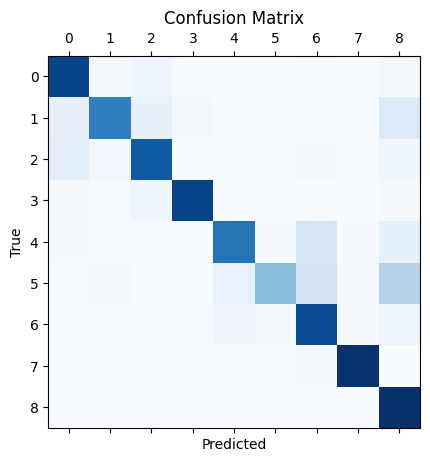

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.838207        0.847557    0.842856          0.971681

                   LOC        MISC          ORG          PER
precision     0.833053    0.690226     0.783140     0.969500
recall        0.891487    0.653846     0.810957     0.923933
f1            0.861280    0.671544     0.796806     0.946168
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 15%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.477642297744751, 'eval_precision': 0.011363636363636364, 'eval_recall': 0.0008852691218130312, 'eval_f1': 0.00164257555847569, 'eval_accuracy': 0.8171207063637342, 'eval_runtime': 7.1646, 'eval_samples_per_second': 481.956, 'eval_steps_per_second': 7.537, 'epoch': 0.45}


 18%|█▊        | 120/660 [00:21<00:57,  9.31it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 120/660 [00:28<00:57,  9.31it/s]

{'eval_loss': 0.6302682757377625, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.1748, 'eval_samples_per_second': 481.265, 'eval_steps_per_second': 7.526, 'epoch': 0.91}


 27%|██▋       | 180/660 [00:42<00:51,  9.26it/s]

{'eval_loss': 0.33567339181900024, 'eval_precision': 0.4072249589490969, 'eval_recall': 0.4830028328611898, 'eval_f1': 0.4418887179071839, 'eval_accuracy': 0.9148056422956822, 'eval_runtime': 7.2687, 'eval_samples_per_second': 475.048, 'eval_steps_per_second': 7.429, 'epoch': 1.36}


 36%|███▋      | 240/660 [00:59<00:45,  9.25it/s]

{'eval_loss': 0.20542363822460175, 'eval_precision': 0.6278019674246089, 'eval_recall': 0.689270538243626, 'eval_f1': 0.6571018651362984, 'eval_accuracy': 0.9462689781414881, 'eval_runtime': 7.4291, 'eval_samples_per_second': 464.796, 'eval_steps_per_second': 7.269, 'epoch': 1.82}


 45%|████▌     | 300/660 [01:13<00:37,  9.65it/s]

{'eval_loss': 0.14254127442836761, 'eval_precision': 0.7960980662983426, 'eval_recall': 0.8163951841359773, 'eval_f1': 0.8061188811188812, 'eval_accuracy': 0.9652848067190697, 'eval_runtime': 7.4124, 'eval_samples_per_second': 465.842, 'eval_steps_per_second': 7.285, 'epoch': 2.27}


 55%|█████▍    | 360/660 [01:29<00:30,  9.82it/s]

{'eval_loss': 0.12379676103591919, 'eval_precision': 0.8110749185667753, 'eval_recall': 0.8376416430594901, 'eval_f1': 0.8241442383067676, 'eval_accuracy': 0.9695272962205234, 'eval_runtime': 7.5294, 'eval_samples_per_second': 458.601, 'eval_steps_per_second': 7.172, 'epoch': 2.73}


 64%|██████▎   | 420/660 [01:45<00:25,  9.26it/s]

{'eval_loss': 0.11428847908973694, 'eval_precision': 0.8419693578929248, 'eval_recall': 0.8659702549575071, 'eval_f1': 0.8538011695906433, 'eval_accuracy': 0.973317540648218, 'eval_runtime': 7.3631, 'eval_samples_per_second': 468.96, 'eval_steps_per_second': 7.334, 'epoch': 3.18}


 73%|███████▎  | 480/660 [02:00<00:18,  9.72it/s]

{'eval_loss': 0.11468861252069473, 'eval_precision': 0.8453162806774974, 'eval_recall': 0.8659702549575071, 'eval_f1': 0.8555186286513905, 'eval_accuracy': 0.9736190373640573, 'eval_runtime': 7.3032, 'eval_samples_per_second': 472.805, 'eval_steps_per_second': 7.394, 'epoch': 3.64}


 76%|███████▌  | 501/660 [02:04<00:19,  8.20it/s]

{'loss': 0.4614, 'learning_rate': 2e-05, 'epoch': 3.79}


 82%|████████▏ | 540/660 [02:16<00:13,  8.62it/s]

{'eval_loss': 0.1124972477555275, 'eval_precision': 0.86223691076709, 'eval_recall': 0.8776558073654391, 'eval_f1': 0.8698780380801965, 'eval_accuracy': 0.9749327016259287, 'eval_runtime': 7.2327, 'eval_samples_per_second': 477.416, 'eval_steps_per_second': 7.466, 'epoch': 4.09}


 91%|█████████ | 600/660 [02:32<00:06,  9.35it/s]

{'eval_loss': 0.1250215768814087, 'eval_precision': 0.8597952455318411, 'eval_recall': 0.8773016997167139, 'eval_f1': 0.8684602576461309, 'eval_accuracy': 0.9753849466996878, 'eval_runtime': 7.2084, 'eval_samples_per_second': 479.025, 'eval_steps_per_second': 7.491, 'epoch': 4.55}


100%|██████████| 660/660 [02:47<00:00, 10.74it/s]

{'eval_loss': 0.11920807510614395, 'eval_precision': 0.8720727018524991, 'eval_recall': 0.8834985835694051, 'eval_f1': 0.8777484608619174, 'eval_accuracy': 0.9766555400021536, 'eval_runtime': 7.188, 'eval_samples_per_second': 480.383, 'eval_steps_per_second': 7.513, 'epoch': 5.0}


100%|██████████| 660/660 [02:49<00:00,  3.90it/s]


{'train_runtime': 169.314, 'train_samples_per_second': 62.192, 'train_steps_per_second': 3.898, 'train_loss': 0.35673225359483196, 'epoch': 5.0}


100%|██████████| 54/54 [00:07<00:00,  7.55it/s]


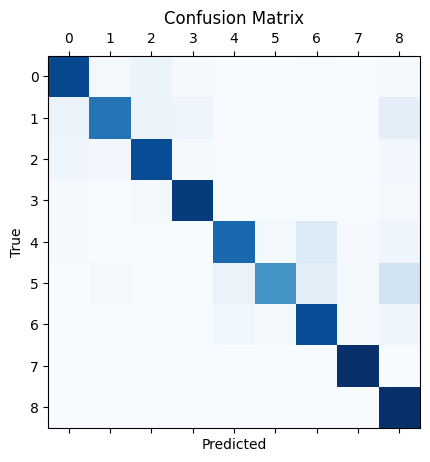

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.862237        0.877656    0.869878          0.974933

                   LOC        MISC          ORG          PER
precision     0.890616    0.703652     0.825086     0.942189
recall        0.893285    0.713675     0.863335     0.947434
f1            0.891949    0.708628     0.843778     0.944804
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 17%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.7369072437286377, 'eval_precision': 0.02598836781270706, 'eval_recall': 0.0625, 'eval_f1': 0.036711559461286465, 'eval_accuracy': 0.6124259717885215, 'eval_runtime': 7.3661, 'eval_samples_per_second': 468.772, 'eval_steps_per_second': 7.331, 'epoch': 0.4}


 16%|█▌        | 119/750 [00:21<01:09,  9.04it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 120/750 [00:28<01:09,  9.04it/s]

{'eval_loss': 0.6107040047645569, 'eval_precision': 0.10344827586206896, 'eval_recall': 0.0005311614730878187, 'eval_f1': 0.0010568962480183197, 'eval_accuracy': 0.8253903305696134, 'eval_runtime': 7.4323, 'eval_samples_per_second': 464.596, 'eval_steps_per_second': 7.266, 'epoch': 0.8}


 24%|██▍       | 180/750 [00:36<01:02,  9.12it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 180/750 [00:43<01:02,  9.12it/s]

{'eval_loss': 0.33055824041366577, 'eval_precision': 0.4640098856966327, 'eval_recall': 0.5318696883852692, 'eval_f1': 0.4956277841940274, 'eval_accuracy': 0.9198880155055453, 'eval_runtime': 7.242, 'eval_samples_per_second': 476.802, 'eval_steps_per_second': 7.457, 'epoch': 1.2}


 32%|███▏      | 240/750 [00:58<00:50, 10.04it/s]

{'eval_loss': 0.18858592212200165, 'eval_precision': 0.6625355886786133, 'eval_recall': 0.7004249291784702, 'eval_f1': 0.6809536104656165, 'eval_accuracy': 0.9489824485840422, 'eval_runtime': 7.2077, 'eval_samples_per_second': 479.073, 'eval_steps_per_second': 7.492, 'epoch': 1.6}


 40%|████      | 300/750 [01:13<00:49,  9.17it/s]

{'eval_loss': 0.13773928582668304, 'eval_precision': 0.7727041249363436, 'eval_recall': 0.8059490084985835, 'eval_f1': 0.7889765144293266, 'eval_accuracy': 0.9640572843760095, 'eval_runtime': 7.2825, 'eval_samples_per_second': 474.153, 'eval_steps_per_second': 7.415, 'epoch': 2.0}


 48%|████▊     | 360/750 [01:28<00:42,  9.25it/s]

{'eval_loss': 0.1194927841424942, 'eval_precision': 0.8317724592438432, 'eval_recall': 0.8491501416430595, 'eval_f1': 0.8403714736288769, 'eval_accuracy': 0.9712932055561537, 'eval_runtime': 7.3191, 'eval_samples_per_second': 471.783, 'eval_steps_per_second': 7.378, 'epoch': 2.4}


 56%|█████▌    | 420/750 [01:44<00:36,  9.11it/s]

{'eval_loss': 0.11808677762746811, 'eval_precision': 0.811864406779661, 'eval_recall': 0.8480878186968839, 'eval_f1': 0.829580879806027, 'eval_accuracy': 0.970582534725961, 'eval_runtime': 7.4139, 'eval_samples_per_second': 465.748, 'eval_steps_per_second': 7.284, 'epoch': 2.8}


 64%|██████▍   | 480/750 [01:58<00:28,  9.49it/s]

{'eval_loss': 0.12384625524282455, 'eval_precision': 0.8407094885483037, 'eval_recall': 0.8643767705382436, 'eval_f1': 0.852378873854212, 'eval_accuracy': 0.9733821470873264, 'eval_runtime': 7.1204, 'eval_samples_per_second': 484.942, 'eval_steps_per_second': 7.584, 'epoch': 3.2}


 67%|██████▋   | 501/750 [02:01<00:28,  8.59it/s]

{'loss': 0.5179, 'learning_rate': 2e-05, 'epoch': 3.33}


 72%|███████▏  | 540/750 [02:12<00:20, 10.12it/s]

{'eval_loss': 0.11309953033924103, 'eval_precision': 0.8667596791070806, 'eval_recall': 0.8799575070821529, 'eval_f1': 0.8733087330873308, 'eval_accuracy': 0.9765693980833423, 'eval_runtime': 7.0641, 'eval_samples_per_second': 488.807, 'eval_steps_per_second': 7.644, 'epoch': 3.6}


 80%|████████  | 600/750 [02:27<00:13, 11.06it/s]

{'eval_loss': 0.1164088100194931, 'eval_precision': 0.8549072971593809, 'eval_recall': 0.8898725212464589, 'eval_f1': 0.8720395592955668, 'eval_accuracy': 0.9746096694303865, 'eval_runtime': 7.0785, 'eval_samples_per_second': 487.816, 'eval_steps_per_second': 7.629, 'epoch': 4.0}


 88%|████████▊ | 660/750 [02:41<00:09,  9.47it/s]

{'eval_loss': 0.1240091621875763, 'eval_precision': 0.8503250085528566, 'eval_recall': 0.8801345609065155, 'eval_f1': 0.8649730294066469, 'eval_accuracy': 0.9745235275115753, 'eval_runtime': 7.0811, 'eval_samples_per_second': 487.638, 'eval_steps_per_second': 7.626, 'epoch': 4.4}


 96%|█████████▌| 720/750 [02:55<00:03,  9.83it/s]

{'eval_loss': 0.11741720885038376, 'eval_precision': 0.8660096818810512, 'eval_recall': 0.8868626062322946, 'eval_f1': 0.8763121063680895, 'eval_accuracy': 0.9766770754818563, 'eval_runtime': 7.155, 'eval_samples_per_second': 482.598, 'eval_steps_per_second': 7.547, 'epoch': 4.8}


100%|██████████| 750/750 [03:00<00:00,  4.15it/s]


{'train_runtime': 180.5166, 'train_samples_per_second': 66.088, 'train_steps_per_second': 4.155, 'train_loss': 0.35480552291870115, 'epoch': 5.0}


100%|██████████| 54/54 [00:06<00:00,  8.00it/s]


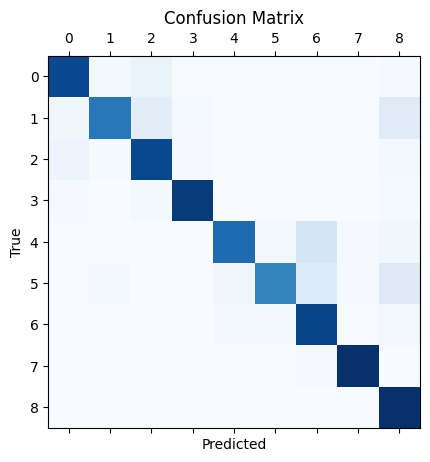

   overall_precision  overall_recall  overall_f1  overall_accuracy
0            0.86676        0.879958    0.873309          0.976569

                   LOC        MISC          ORG          PER
precision     0.895088    0.747748     0.801639     0.962240
recall        0.884892    0.709402     0.883203     0.945578
f1            0.889961    0.728070     0.840447     0.953837
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------
---------------------------------------------------
starting run on training set of 19%



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

{'eval_loss': 1.4875688552856445, 'eval_precision': 0.04794520547945205, 'eval_recall': 0.007436260623229462, 'eval_f1': 0.012875536480686697, 'eval_accuracy': 0.8124475072682243, 'eval_runtime': 7.2386, 'eval_samples_per_second': 477.025, 'eval_steps_per_second': 7.46, 'epoch': 0.36}


 14%|█▍        | 119/835 [00:20<01:10, 10.10it/s]/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 120/835 [00:28<01:10, 10.10it/s]

{'eval_loss': 0.6266493797302246, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8253041886508022, 'eval_runtime': 7.2884, 'eval_samples_per_second': 473.769, 'eval_steps_per_second': 7.409, 'epoch': 0.72}


 22%|██▏       | 180/835 [00:42<01:05, 10.02it/s]

{'eval_loss': 0.3351520895957947, 'eval_precision': 0.43187622051975366, 'eval_recall': 0.5090297450424929, 'eval_f1': 0.4672897196261683, 'eval_accuracy': 0.918918918918919, 'eval_runtime': 7.3162, 'eval_samples_per_second': 471.967, 'eval_steps_per_second': 7.381, 'epoch': 1.08}


 29%|██▊       | 240/835 [00:57<01:02,  9.48it/s]

{'eval_loss': 0.19075767695903778, 'eval_precision': 0.6719698212235525, 'eval_recall': 0.7253895184135978, 'eval_f1': 0.6976585781183483, 'eval_accuracy': 0.9514159577904597, 'eval_runtime': 7.2405, 'eval_samples_per_second': 476.904, 'eval_steps_per_second': 7.458, 'epoch': 1.44}


 36%|███▌      | 300/835 [01:12<00:57,  9.38it/s]

{'eval_loss': 0.13467612862586975, 'eval_precision': 0.7762154836523801, 'eval_recall': 0.8112606232294618, 'eval_f1': 0.7933512250021644, 'eval_accuracy': 0.9652848067190697, 'eval_runtime': 7.3941, 'eval_samples_per_second': 466.995, 'eval_steps_per_second': 7.303, 'epoch': 1.8}


 43%|████▎     | 360/835 [01:28<00:54,  8.69it/s]

{'eval_loss': 0.13395100831985474, 'eval_precision': 0.7940981432360743, 'eval_recall': 0.8480878186968839, 'eval_f1': 0.8202054794520549, 'eval_accuracy': 0.9670937870141058, 'eval_runtime': 7.4663, 'eval_samples_per_second': 462.476, 'eval_steps_per_second': 7.232, 'epoch': 2.16}


 50%|█████     | 420/835 [01:43<00:43,  9.57it/s]

{'eval_loss': 0.11578770726919174, 'eval_precision': 0.8378006872852234, 'eval_recall': 0.863314447592068, 'eval_f1': 0.8503662364841299, 'eval_accuracy': 0.9723915150209971, 'eval_runtime': 7.263, 'eval_samples_per_second': 475.422, 'eval_steps_per_second': 7.435, 'epoch': 2.51}


 57%|█████▋    | 480/835 [01:59<00:39,  8.98it/s]

{'eval_loss': 0.10862652212381363, 'eval_precision': 0.8418817934782609, 'eval_recall': 0.8776558073654391, 'eval_f1': 0.8593966712898753, 'eval_accuracy': 0.9735113599655433, 'eval_runtime': 7.2946, 'eval_samples_per_second': 473.365, 'eval_steps_per_second': 7.403, 'epoch': 2.87}


 60%|██████    | 502/835 [02:03<00:35,  9.25it/s]

{'loss': 0.4661, 'learning_rate': 2e-05, 'epoch': 2.99}


 65%|██████▍   | 540/835 [02:15<00:32,  8.97it/s]

{'eval_loss': 0.11162999272346497, 'eval_precision': 0.862731521550978, 'eval_recall': 0.8824362606232294, 'eval_f1': 0.872472647702407, 'eval_accuracy': 0.9753203402605793, 'eval_runtime': 7.3477, 'eval_samples_per_second': 469.94, 'eval_steps_per_second': 7.349, 'epoch': 3.23}


 72%|███████▏  | 600/835 [02:29<00:27,  8.44it/s]

{'eval_loss': 0.11341233551502228, 'eval_precision': 0.8686030428769018, 'eval_recall': 0.8895184135977338, 'eval_f1': 0.8789363191042688, 'eval_accuracy': 0.9768278238397761, 'eval_runtime': 7.25, 'eval_samples_per_second': 476.273, 'eval_steps_per_second': 7.448, 'epoch': 3.59}


 79%|███████▉  | 660/835 [02:45<00:17, 10.15it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.2407, 'eval_samples_per_second': 476.886, 'eval_steps_per_second': 7.458, 'epoch': 3.95}


 86%|████████▌ | 720/835 [03:00<00:12,  9.09it/s]

{'eval_loss': 0.11173135042190552, 'eval_precision': 0.8698523023457863, 'eval_recall': 0.8863314447592068, 'eval_f1': 0.8780145575725686, 'eval_accuracy': 0.9765909335630452, 'eval_runtime': 7.3895, 'eval_samples_per_second': 467.282, 'eval_steps_per_second': 7.308, 'epoch': 4.31}


 93%|█████████▎| 780/835 [03:15<00:05,  9.50it/s]

{'eval_loss': 0.1188024953007698, 'eval_precision': 0.8719819350356088, 'eval_recall': 0.8888101983002833, 'eval_f1': 0.8803156510302499, 'eval_accuracy': 0.9765047916442339, 'eval_runtime': 7.2422, 'eval_samples_per_second': 476.787, 'eval_steps_per_second': 7.456, 'epoch': 4.67}


100%|██████████| 835/835 [03:23<00:00,  4.10it/s]


{'train_runtime': 203.5244, 'train_samples_per_second': 65.52, 'train_steps_per_second': 4.103, 'train_loss': 0.28902196827049026, 'epoch': 5.0}


100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


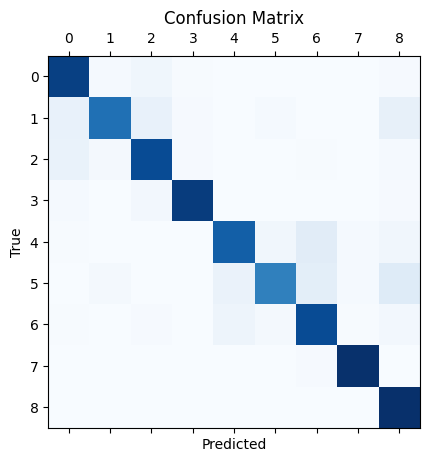

   overall_precision  overall_recall  overall_f1  overall_accuracy
0           0.861345        0.886508    0.873746          0.976096

                   LOC        MISC          ORG          PER
precision     0.860034    0.707756     0.830167     0.967619
recall        0.917266    0.727920     0.868152     0.942486
f1            0.887728    0.717697     0.848735     0.954887
number     1668.000000  702.000000  1661.000000  1617.000000

end of run
---------------------------------------------------


  7%|▋         | 60/835 [00:13<01:24,  9.19it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.2875, 'eval_samples_per_second': 473.828, 'eval_steps_per_second': 7.41, 'epoch': 0.36}


 14%|█▍        | 120/835 [00:28<01:19,  9.02it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.3671, 'eval_samples_per_second': 468.705, 'eval_steps_per_second': 7.33, 'epoch': 0.72}


 22%|██▏       | 180/835 [00:43<01:12,  9.01it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.2582, 'eval_samples_per_second': 475.74, 'eval_steps_per_second': 7.44, 'epoch': 1.08}


 29%|██▊       | 240/835 [00:58<01:02,  9.54it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.2474, 'eval_samples_per_second': 476.447, 'eval_steps_per_second': 7.451, 'epoch': 1.44}


 36%|███▌      | 300/835 [01:13<00:58,  9.22it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.2442, 'eval_samples_per_second': 476.656, 'eval_steps_per_second': 7.454, 'epoch': 1.8}


 43%|████▎     | 360/835 [01:28<00:52,  9.03it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.4044, 'eval_samples_per_second': 466.347, 'eval_steps_per_second': 7.293, 'epoch': 2.16}


 50%|█████     | 420/835 [01:43<00:41, 10.06it/s]

{'eval_loss': 0.1083892285823822, 'eval_precision': 0.8613452606227421, 'eval_recall': 0.8865084985835694, 'eval_f1': 0.8737457464444638, 'eval_accuracy': 0.9760956175298805, 'eval_runtime': 7.2999, 'eval_samples_per_second': 473.022, 'eval_steps_per_second': 7.397, 'epoch': 2.51}


 50%|█████     | 420/835 [01:45<01:44,  3.98it/s]

{'train_runtime': 105.65, 'train_samples_per_second': 126.219, 'train_steps_per_second': 7.903, 'train_loss': 0.019532065164475212, 'epoch': 2.51}


TrainOutput(global_step=420, training_loss=0.019532065164475212, metrics={'train_runtime': 105.65, 'train_samples_per_second': 126.219, 'train_steps_per_second': 7.903, 'train_loss': 0.019532065164475212, 'epoch': 2.51})

In [15]:
import numpy as np

for k in range(1, 20, 2):
    print("---------------------------------------------------")
    print(f"starting run on training set of {k}%")
    print()
    model = reload_model()
    dataset = load_dataset(k)
    trainer = reload_trainer(f"./logs_results/run_{k}%_data/", dataset, model)
    trainer.train()
    results = eval(trainer, dataset)
    pretty_print(results)
    print()
    print("end of run")
    print("---------------------------------------------------")

trainer.train()